# Getting and exploring data #
This is our first contact with the data. We'll download it, explore it and repackage it for preprocessing

In [2]:
%matplotlib inline
from __future__ import print_function
from matplotlib import pyplot as plt
import collections
import os, struct
import numpy as np
import scipy as sp
import scipy.io
import random
import math
from random import randint
import string
import tensorflow as tf
import gzip
import zlib
import tarfile
import pandas as pd
from six.moves import range
from six.moves.urllib.request import urlretrieve
from array import array as pyarray 
from six.moves import cPickle as pickle
from scipy.misc import imresize
from IPython.display import Image, display
from os import listdir
import skimage
from skimage import data
from skimage import exposure
from skimage import img_as_ubyte
from skimage.transform import resize
from skimage.transform import rescale
from skimage.transform import rotate
from skimage import novice

In [3]:
def maybe_download(base_url, dest_folder, filename, expected_bytes=None):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    filepath = os.path.join(dest_folder,filename)
    if not os.path.exists(filepath):
        filepath, _ = urlretrieve(base_url + filename, filepath)
    statinfo = os.stat(filepath)
    if expected_bytes is None or statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

def maybe_untargz(filename, dest_folder,force=False):
    extraction_dir = filename.split(".")[0]
    if not os.path.isdir(extraction_dir):
        tar = tarfile.open(filename, "r:gz")
        tar.extractall(dest_folder)
        tar.close()
        print (filename + " extracted to " + extraction_dir)
    else:
        print ("Folder " + extraction_dir + " already exists. Skipping")
        
def saveAsPickle(data,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            print (filename + " pickled!")
    except Exception as e:
        print('Unable to save data to', filename, ':', e)
        
def loadPickle(file):
    with open(file, 'rb') as pickle_file:
        return pickle.load(pickle_file)
    

        

## Getting the data

The SVHN dataset comes in two flavors.

- Format 1: pictures of various sizes and resolutions of full street numbers accompanied with metadata containing bounding boxes coordinates for each digit. The training set contains 73257 pictures, the testing set 26032 and there is an _extra_ dataset of 531131 additional samples described as _somewhat less difficult_. The images are in .png formats and the metadata file is provided as a Matlab .mat file.
- Format 2: Cropped 32x32 digits in a Matlab file file format

We won't use Format 2 as we'll follow Goodfellow et Al's approach of feeding the model with images of street numbers. So we'll use Format 1 dataset.

The code below downloads and uncompresses the dataset.

In [4]:
svhn_base_url = "http://ufldl.stanford.edu/housenumbers/"
svhn_dest_folder = "data/svhn/"

svhn_train_format_1 = maybe_download(svhn_base_url,svhn_dest_folder, "train.tar.gz")
svhn_test_format_1 = maybe_download(svhn_base_url,svhn_dest_folder, "test.tar.gz")
svhn_extra_format_1 = maybe_download(svhn_base_url,svhn_dest_folder, "extra.tar.gz")

     
maybe_untargz(os.path.join(svhn_dest_folder,"train.tar.gz"), svhn_dest_folder)
maybe_untargz(os.path.join(svhn_dest_folder,"test.tar.gz"), svhn_dest_folder)
maybe_untargz(os.path.join(svhn_dest_folder,"extra.tar.gz"), svhn_dest_folder)

Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz
Folder data/svhn/train already exists. Skipping
Folder data/svhn/test already exists. Skipping
Folder data/svhn/extra already exists. Skipping


## Quick Look
A quick first look at the images indicates very diffrent sizes and resolutions

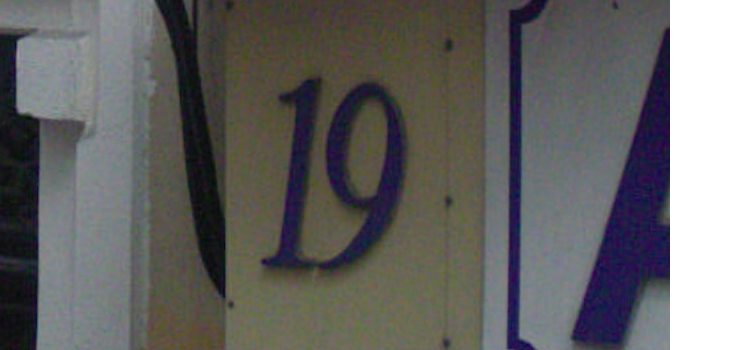

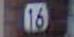

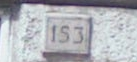

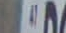

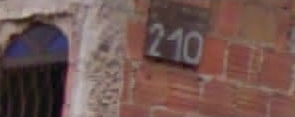

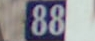

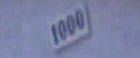

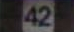

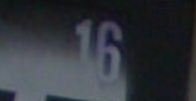

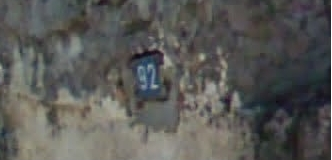

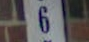

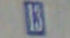

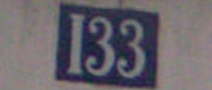

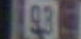

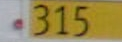

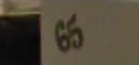

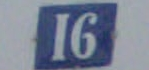

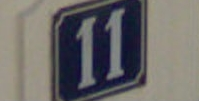

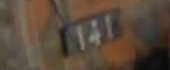

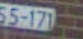

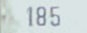

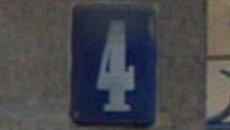

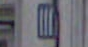

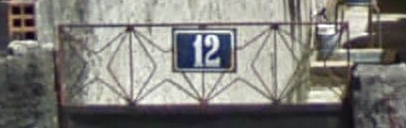

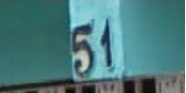

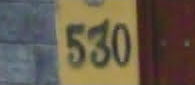

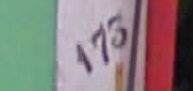

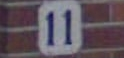

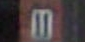

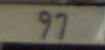

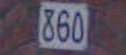

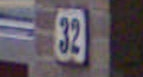

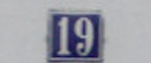

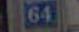

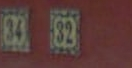

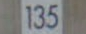

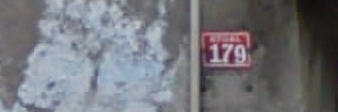

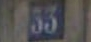

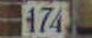

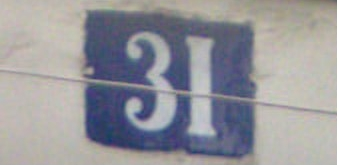

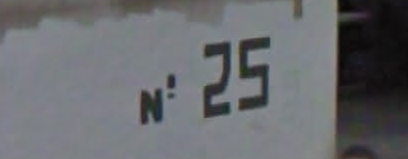

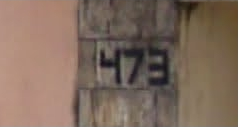

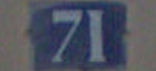

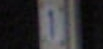

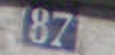

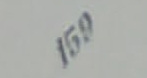

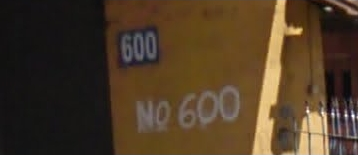

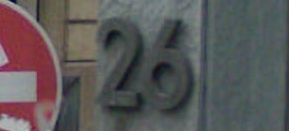

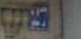

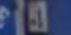

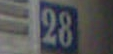

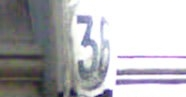

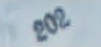

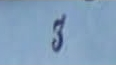

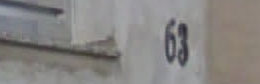

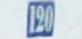

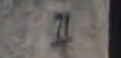

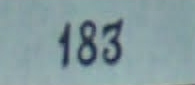

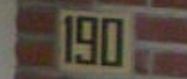

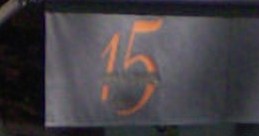

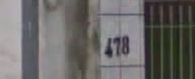

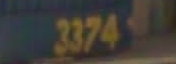

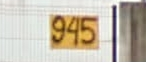

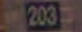

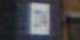

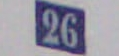

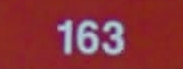

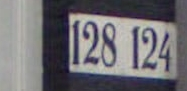

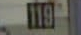

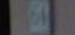

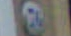

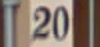

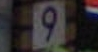

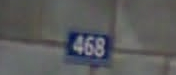

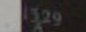

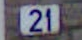

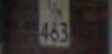

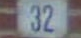

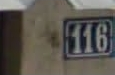

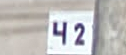

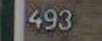

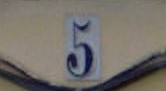

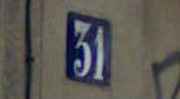

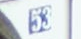

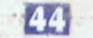

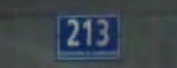

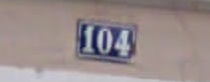

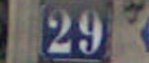

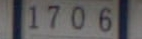

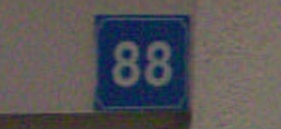

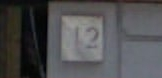

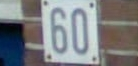

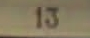

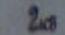

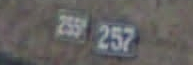

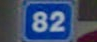

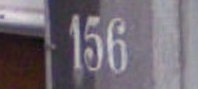

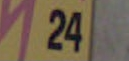

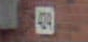

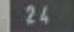

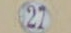

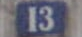

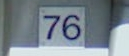

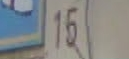

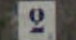

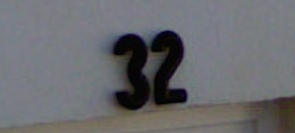

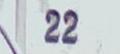

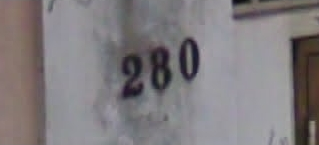

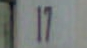

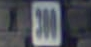

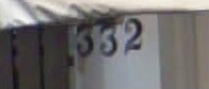

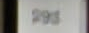

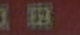

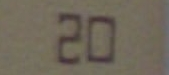

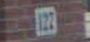

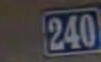

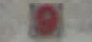

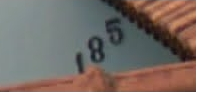

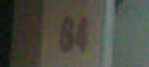

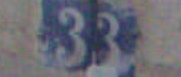

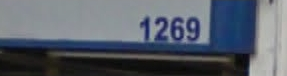

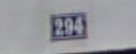

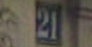

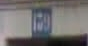

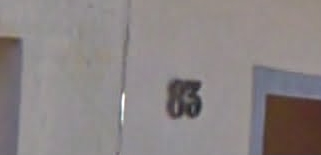

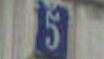

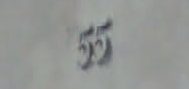

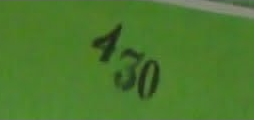

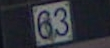

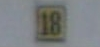

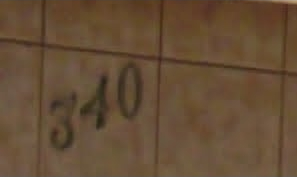

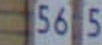

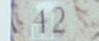

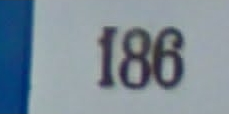

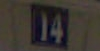

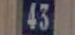

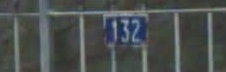

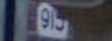

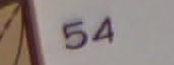

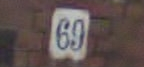

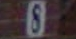

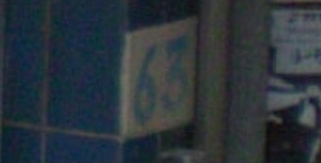

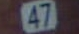

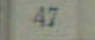

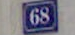

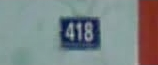

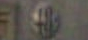

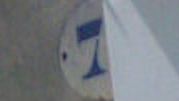

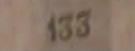

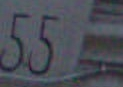

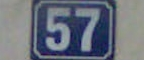

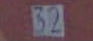

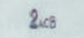

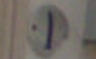

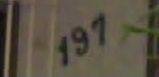

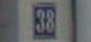

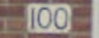

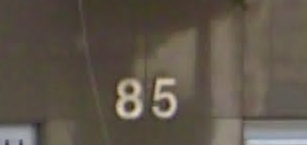

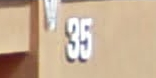

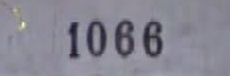

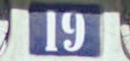

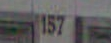

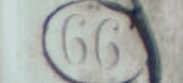

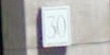

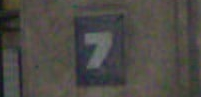

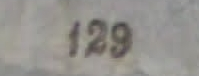

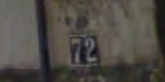

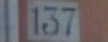

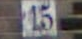

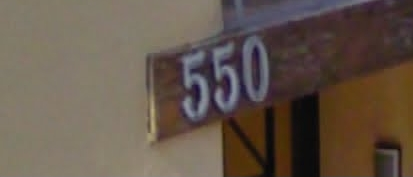

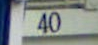

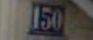

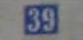

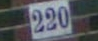

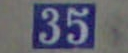

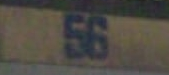

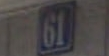

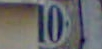

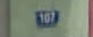

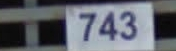

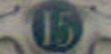

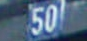

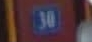

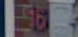

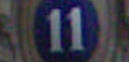

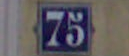

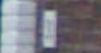

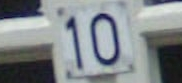

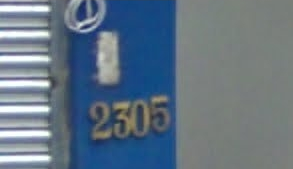

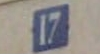

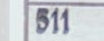

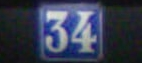

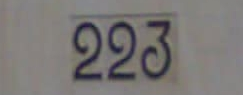

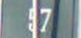

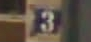

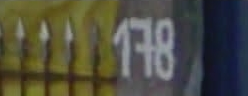

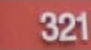

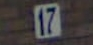

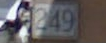

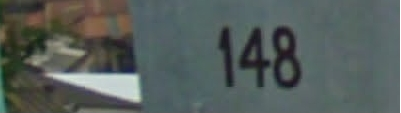

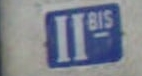

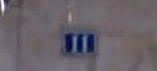

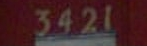

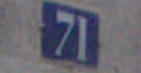

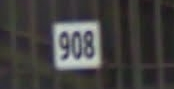

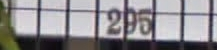

In [5]:
imagesPath = os.path.join(svhn_dest_folder,'train')
imagesNames = [f for f in os.listdir(imagesPath) if f.endswith('.png')][:300]
for imageName in imagesNames:
    display(Image(filename=os.path.join(imagesPath,imageName)))

Aa better idea of how dimensions are distributed could help. But first, let's have a look at the metadata.


## Metadata
The metadata is provided as a Matlab .mat file. The first step is to convert it to a .csv file we can easily load in a dataframe and manipulate.

In [6]:
# using https://github.com/sarahrn/Py-Gsvhn-DigitStruct-Reader to convert .mat files to .csv
import digitStructMatToCsv
def matToCsv(sourceMat, destCsv, force=False):
    if (os.path.isfile(destCsv)):
        print (sourceMat + " already converted to " + destCsv)
    else:
        csvFile = open(destCsv, 'wb')
        digitStructMatToCsv.writeToCsvFile(sourceMat, csvFile)
        csvFile.close()
        print (sourceMat + " converted to " + destCsv)

# Convert
matToCsv(os.path.join(svhn_dest_folder,"train","digitStruct.mat")
         ,os.path.join(svhn_dest_folder,"train","digitStruct.csv"))
matToCsv(os.path.join(svhn_dest_folder,"test","digitStruct.mat")
         ,os.path.join(svhn_dest_folder,"test","digitStruct.csv"))
matToCsv(os.path.join(svhn_dest_folder,"extra","digitStruct.mat")
         ,os.path.join(svhn_dest_folder,"extra","digitStruct.csv"))

# Display 
svhn_train_digit_info = pd.read_csv(os.path.join(svhn_dest_folder,"train","digitStruct.csv"))
svhn_test_digit_info = pd.read_csv(os.path.join(svhn_dest_folder,"test","digitStruct.csv"))
svhn_extra_digit_info = pd.read_csv(os.path.join(svhn_dest_folder,"extra","digitStruct.csv"))
display(svhn_train_digit_info.head())
display(svhn_test_digit_info.head())
display(svhn_extra_digit_info.head())

data/svhn/train/digitStruct.mat already converted to data/svhn/train/digitStruct.csv
data/svhn/test/digitStruct.mat already converted to data/svhn/test/digitStruct.csv
data/svhn/extra/digitStruct.mat already converted to data/svhn/extra/digitStruct.csv


FileName  DigitLabel  Left  Top  Width  Height
0    1.png           1   246   77     81     219
1    1.png           9   323   81     96     219
2    2.png           2    77   29     23      32
3    2.png           3    98   25     26      32
4    3.png           2    17    5      8      15

FileName  DigitLabel  Left  Top  Width  Height
0    1.png           5    43    7     19      30
1    2.png           2    99    5     14      23
2    2.png           1   114    8      8      23
3    2.png          10   121    6     12      23
4    3.png           6    61    6     11      16

FileName  DigitLabel  Left  Top  Width  Height
0    1.png           4    24   70     38      56
1    1.png           7    55   41     36      56
2    1.png           8    79   23     47      56
3    2.png           7    32   13     94     203
4    2.png           1   143   33     38     203

I am going to recompile the meta data table in a more usable format. Having the whole street number information in one row will be easier.
The following method does that. **Note that this operation takes a long time, up to a couple of hours**.

In [7]:
def create_svhn_metadata(image_folder,dataframe):
    df = pd.DataFrame(columns=('filename', 'value', 'digits', 'length', 'width', 'height','box'))
    current_image_file = ""
    digits = []
    left = top = 999999
    right = bottom = 0
    for i,row in dataframe.iterrows():
        
        if current_image_file != row['FileName']:
            if len(digits) > 0:
                img = novice.open(os.path.join(image_folder,current_image_file))
                df.loc[len(df)] = [current_image_file ,int("".join(str(x) for x in digits)), digits, len(digits), img.width, img.height,[left,top,right,bottom]]
            current_image_file = row['FileName']
            digits = []
            left = top = 999999
            right = bottom = 0
            
        # Since 0 are encoded as 10 in the mat and csv. we substite 10 with 0    
        digit = 0 if row['DigitLabel'] == 10 else row['DigitLabel']
        # The street number surrounding crop box
        left = min(row['Left'],left)
        top = min(row['Top'],top)
        right = max(row['Left'] + row['Width'],right)
        bottom = max(row['Top'] + row['Height'],bottom)
        digits.append(digit)

    return df

In [8]:
svhn_train_df = create_svhn_metadata(os.path.join(svhn_dest_folder,"train"),svhn_train_digit_info)
svhn_test_df = create_svhn_metadata(os.path.join(svhn_dest_folder,"test"),svhn_test_digit_info)
svhn_extra_df = create_svhn_metadata(os.path.join(svhn_dest_folder,"extra"),svhn_extra_digit_info)

saveAsPickle(svhn_train_df, os.path.join(svhn_dest_folder,"train","digitStruct.dataframe"))
saveAsPickle(svhn_test_df, os.path.join(svhn_dest_folder,"test","digitStruct.dataframe"))
saveAsPickle(svhn_extra_df, os.path.join(svhn_dest_folder,"extra","digitStruct.dataframe"))

data/svhn/train/digitStruct.dataframe pickled!
data/svhn/test/digitStruct.dataframe pickled!
data/svhn/extra/digitStruct.dataframe pickled!


Now let's see how the meta data with its new structure looks, and let's look at basic statistics about our dataset

In [9]:
svhn_train_df = loadPickle(os.path.join(svhn_dest_folder,"train","digitStruct.dataframe"))
svhn_test_df = loadPickle(os.path.join(svhn_dest_folder,"test","digitStruct.dataframe"))
svhn_extra_df = loadPickle(os.path.join(svhn_dest_folder,"extra","digitStruct.dataframe"))

display(svhn_train_df.head())
display(svhn_test_df.head())
display(svhn_extra_df.head())

print ("TRAINING")
print ("Max value: %d" % int(svhn_train_df['value'].max()))
print ("Min value: %d" % int(svhn_train_df['value'].min()))
print ("Max length: %d" % int(svhn_train_df['length'].max()))
print ("Min length: %d" % int(svhn_train_df['length'].min()))

print ("\nEXTRA")
print ("Max value: %d" % int(svhn_extra_df['value'].max()))
print ("Min value: %d" % int(svhn_extra_df['value'].min()))
print ("Max length: %d" % int(svhn_extra_df['length'].max()))
print ("Min length: %d" % int(svhn_extra_df['length'].min()))

filename  value  digits  length  width  height                  box
0    1.png   19.0  [1, 9]     2.0  741.0   350.0  [246, 77, 419, 300]
1    2.png   23.0  [2, 3]     2.0  199.0    83.0    [77, 25, 124, 61]
2    3.png   25.0  [2, 5]     2.0   52.0    23.0      [17, 5, 34, 20]
3    4.png   93.0  [9, 3]     2.0  161.0    79.0     [57, 13, 85, 47]
4    5.png   31.0  [3, 1]     2.0  140.0    68.0      [52, 7, 89, 56]

filename  value     digits  length  width  height                box
0    1.png    5.0        [5]     1.0   99.0    47.0    [43, 7, 62, 37]
1    2.png  210.0  [2, 1, 0]     3.0  182.0    48.0   [99, 5, 133, 31]
2    3.png    6.0        [6]     1.0  101.0    31.0    [61, 6, 72, 22]
3    4.png    1.0        [1]     1.0   75.0    31.0    [32, 6, 46, 23]
4    5.png    9.0        [9]     1.0  215.0    81.0  [97, 28, 116, 56]

filename  value     digits  length  width  height                 box
0    1.png  478.0  [4, 7, 8]     3.0  166.0   141.0  [24, 23, 126, 126]
1    2.png   71.0     [7, 1]     2.0  295.0   261.0  [32, 13, 181, 236]
2    3.png  174.0  [1, 7, 4]     3.0  137.0    96.0    [18, 5, 106, 81]
3    4.png   30.0     [3, 0]     2.0   79.0    50.0     [11, 6, 55, 44]
4    5.png  288.0  [2, 8, 8]     3.0   81.0    50.0      [8, 5, 63, 43]

TRAINING
Max value: 135458
Min value: 0
Max length: 6
Min length: 1

EXTRA
Max value: 70333
Min value: 0
Max length: 5
Min length: 1


We have street number with zero values, which is uncommon in real life. As shown below, this value is the result of mislabelling. 

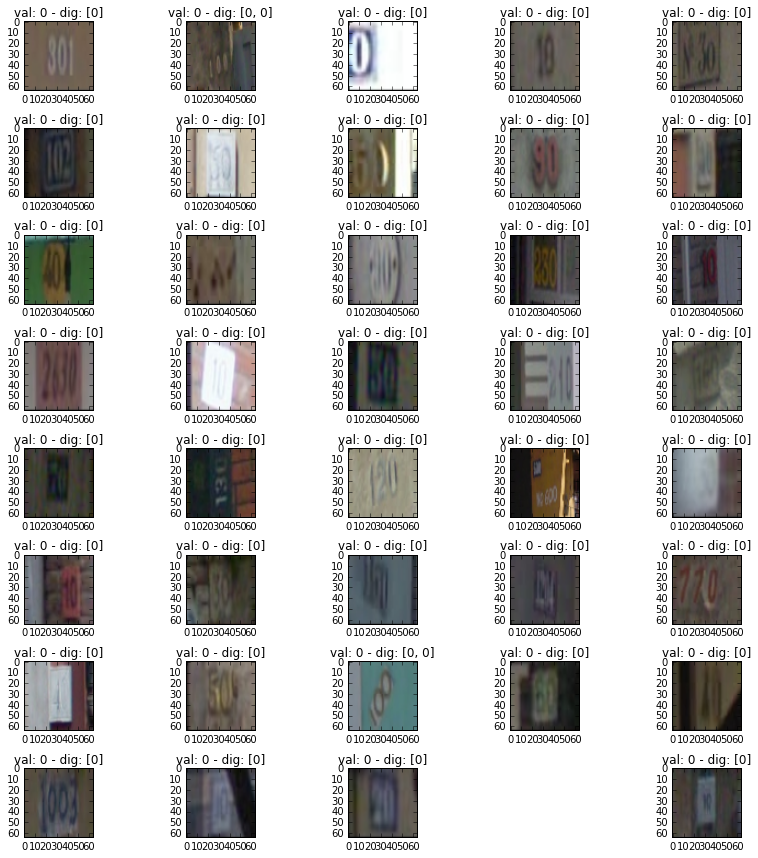

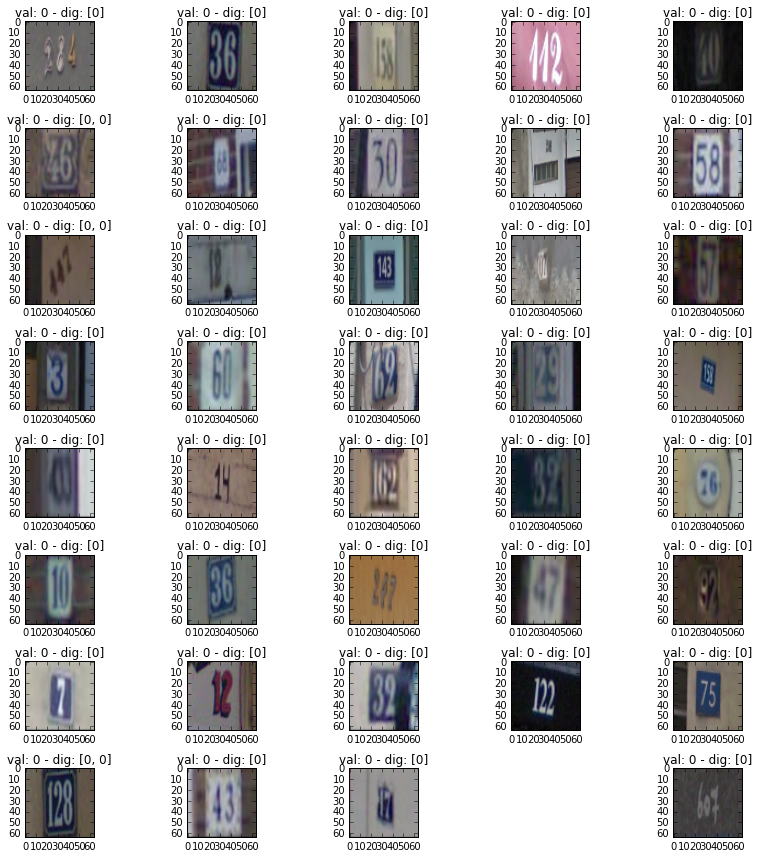

In [10]:
# Display images and metadata corresponding to zero values
def show_zero(df):
    fig = plt.figure(figsize=(12, 12), dpi=80)
    if df.shape[0] == 0:
        print ("No zero values in dataframe.")
        return
    for i in range(min(df.shape[0],40)):
        plt.subplot(8,5,i+1)
        plt.title(str("val: %d - dig: %s" % (int(df.iloc[i]['value']), str(df.iloc[i]['digits']))))
        img_path = os.path.join("data","svhn","train",df.iloc[i]['filename'])
        img = skimage.io.imread(img_path)
        img = resize(image=img,output_shape=(64,64))
        plt.imshow(img)
        plt.tight_layout()
    plt.show()

zero_values_train = svhn_train_df.loc[svhn_train_df['value'] == 0].reset_index(drop=True)
zero_values_extra = svhn_extra_df.loc[svhn_extra_df['value'] == 0].reset_index(drop=True)
show_zero(zero_values_train)
show_zero(zero_values_extra)

Let's remove those items from both the training and test sets and save clean new dataframes

In [11]:
svhn_train_df = svhn_train_df[svhn_train_df.value != 0].reset_index(drop=True)
svhn_test_df = svhn_test_df[svhn_test_df.value != 0].reset_index(drop=True)
svhn_extra_df = svhn_extra_df[svhn_extra_df.value != 0].reset_index(drop=True)
saveAsPickle(svhn_train_df, os.path.join(svhn_dest_folder,"train","digitStruct_nozeros.dataframe"))
saveAsPickle(svhn_test_df, os.path.join(svhn_dest_folder,"test","digitStruct_nozeros.dataframe"))
saveAsPickle(svhn_extra_df, os.path.join(svhn_dest_folder,"extra","digitStruct_nozeros.dataframe"))

data/svhn/train/digitStruct_nozeros.dataframe pickled!
data/svhn/test/digitStruct_nozeros.dataframe pickled!
data/svhn/extra/digitStruct_nozeros.dataframe pickled!


### Dimensions
Now it's easy to see how dimensions are distributed

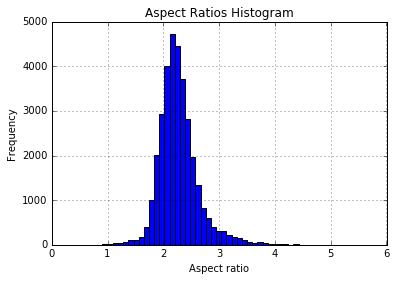

Median width: 104
Median height: 47


In [12]:
plt.title("Widths and heights Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.hist(svhn_train_df['width'],50)
plt.hist(svhn_train_df['height'],50)
plt.grid(True)
fig = plt.show()

plt.title("Aspect Ratios Histogram")
plt.xlabel("Aspect ratio")
plt.ylabel("Frequency")
plt.hist(svhn_train_df['width']/svhn_train_df['height'],50)
plt.grid(True)
fig = plt.show()

print ("Median width: %d" % svhn_train_df['width'].median())
print ("Median height: %d" % svhn_train_df['height'].median())
# print ("Median ratio: %.2f" % images_info['aspect'].median())

## Length
Street numbers my have up to 5 digits which means their values are between 1 and 99999. Let’s see in practices how street numbers length is distributed.


In [13]:
lengths = svhn_train_df['length'].tolist()
bins = int(max(lengths))
n, bins, patches = plt.hist(lengths, bins, normed=1, facecolor='green', alpha=0.5)
plt.xlabel('Length')
plt.ylabel('Probability')
plt.title(r'Distribution of lengths')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

As we could have guessed, most street numbers have one to three digits. About 4% have 4 digits, and the proportions of street numbers with 5 digits or more are negligible.